In [10]:
#%pylab inline 
#import matplotlib.pyplot as plt 
#import numpy as np
#plt.plot(np.sin(np.linspace(0,2*np.pi, 100)))

监督学习的大致流程
- 从未知映射$f$中给定若干数据对$\{\left(x_i, y_i=f\left(x_i\right)\right)\}$
- 构建基函数族$\{\phi(x ; \theta)\}_\theta$
- 确定衡量近似$\phi(x ; \theta) \approx f(x)$的准则：$$
\frac{1}{N} \sum_{i=1}^N \mathcal{L}\left(\phi\left(x_i ; \theta\right), y_i\right) \stackrel{e .g}{=} \frac{1}{N} \sum_{i=1}^N\left(\phi\left(x_i ; \theta\right)-y_i\right)^2
$$
- 用优化算法确定最优$\theta$

不同的的准则和优化算法都可以导出不同的算法：

准则：
- Least square methods (DGM, PINN)
- Variational methods (Deep Ritz)
- Adversarial methods (WAN, Select-Net, Friedrich learning)

优化器：
- SGD with a fixed DNN (most methods)
- Growing width
- Growing depth

接下来看到的算法是一种最小二乘类的算法。我们考虑边值问题：
$$
\begin{array}{ll}
\mathcal{D}(u)=f & \text { in } \Omega, \\
\mathcal{B}(u)=g & \text { on } \partial \Omega .
\end{array}
$$
解决的思路是用一个全连接神经网络函数$\phi\left(\boldsymbol{x} ; \boldsymbol{\theta}^*\right)$来近似PDE的解$u(\boldsymbol{x})$。参数
$$
\begin{aligned}
\boldsymbol{\theta}^* & =\underset{\boldsymbol{\theta}}{\operatorname{argmin}} \mathcal{L}(\boldsymbol{\theta}) ,\\
& :=\underset{\boldsymbol{\theta}}{\operatorname{argmin}}\|\mathcal{D} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-f(\boldsymbol{x})\|_2^2+\lambda\|\mathcal{B} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-g(\boldsymbol{x})\|_2^2 ,\\
& =\underset{\boldsymbol{\theta}}{\operatorname{argmin}} \mathbb{E}_{\boldsymbol{x} \in \Omega}\left[|\mathcal{D} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-f(\boldsymbol{x})|^2\right]+\lambda \mathbb{E}_{\boldsymbol{x} \in \partial \Omega}\left[|\mathcal{B} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-g(\boldsymbol{x})|^2\right], \\
& \approx \underset{\boldsymbol{\theta}}{\operatorname{argmin}} \frac{1}{N_1} \sum_{i=1}^{N_1}\left|\mathcal{D} \phi\left(\boldsymbol{x}_i ; \boldsymbol{\theta}\right)-f\left(\boldsymbol{x}_i\right)\right|^2+\lambda \frac{1}{N_2} \sum_{j=1}^{N_2}\left|\mathcal{B} \phi\left(\boldsymbol{x}_j ; \boldsymbol{\theta}\right)-g\left(\boldsymbol{x}_j\right)\right|^2,
\end{aligned}
$$
其中$\boldsymbol{x}_i\in\Omega$ and $\boldsymbol{x}_j\in\partial \Omega$是任意选择的。但这样会涉及到这些点应该如何选择的问题，这是很困难的事情。接下来考虑在每一步，都随机的生成若干采样点，来生成一个损失函数。这样做的好处是在一定程度上避免了选择点对实验效果的影响。这样算法的流程可以大致表述为
- 随机在内部和边界生成采样点$\Omega^r$和$\partial \Omega^r$
- 生成随机的损失函数$$
\begin{aligned}
\mathcal{L}\left(\boldsymbol{\theta}, \Omega^r, \partial \Omega^r\right):= & \frac{1}{\left|\Omega^r\right|} \sum_{\boldsymbol{x} \in \Omega^r}\left[|\mathcal{D} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-f(\boldsymbol{x})|^2\right] \\
& +\frac{\lambda}{\left|\partial \Omega^r\right|} \sum_{\boldsymbol{x} \in \partial \Omega^r}\left[|\mathcal{B} \phi(\boldsymbol{x} ; \boldsymbol{\theta})-g(\boldsymbol{x})|^2\right] .
\end{aligned}
$$
- 做一步梯度下降
$$
\boldsymbol{\theta} \leftarrow \boldsymbol{\theta}-\alpha \frac{\partial \mathcal{L}\left(\boldsymbol{\theta}, \Omega^r, \partial \Omega^r\right)}{\partial \boldsymbol{\theta}}
$$

上面所说的方法会给求解带来困难，主要在于损失函数是比较复杂的，其由两部分构成：内部损失和边界损失。如果可以通过某种方式简化损失函数，这样就可以给求解带来好处。接下来考虑一种通过选择合适的基函数的方式来简化损失函数，其思想在于基函数可以自动满足边界条件，这样损失函数就简化成只有内部项了。

Dirichlet 边界条件 （以一维为例$u(a)=a_0, u(b)=b_0$）：
- 在原始神经网络$\hat{u}(x ; \theta)$的基础上增加$h_1(x)$ 和 $l_1(x)$来获得新的神经网络
$$
u(x ; \theta)=h_1(x) \hat{u}(x ; \theta)+l_1(x)
$$
- $I_1(a)=a_0, I_1(b)=b_0$， $h_1(a)=0, h_1(b)=0$
- 例如：$$
l_1(x)=\left(b_0-a_0\right)(x-a) /(b-a)+a_0 ，
$$
$$
h_1(x)=(x-a)^{p_a}(x-b)^{p_b},
$$
其中 $0<p_a, p_b \leq 1$


接下来求解B-S方程作为例子来说明如何用神经网络来求解PDE。 torch版本是1.13.1

In [11]:
import torch

美式期权定价需要求解的线性互补问题是：
$$
\mathcal{L} u \geq 0, \quad u \geq g \quad \text { 和 } \quad \mathcal{L} u(u-g)=0 \text {. }
$$
特别地，Black-Scholes偏微分方程算子$\mathcal{L}_{B S}$可以表示为：
$$
\mathcal{L}_{B S}:=-\frac{\partial}{\partial t}-\frac{1}{2} \sigma^2 x^2 \frac{\partial^2}{\partial x^2}-r x \frac{\partial}{\partial x}+r,
$$
其中$(x, t) \in[0,+\infty] \times[0, T]$，$x$是原生资产价格，$t$是时间，$r$是无风险利率，$\sigma$是波动率.
$$\sigma = 0.6;\quad          \% volatility$$
$$r = 0.25;\quad              \% interest rate $$
$$K = 10; \quad               \% strike price$$
$$S_{\max } = 50; \quad               \% asset value$$
$$T = 1; \quad                \% time$$
对于看涨期权：
$$
u(0, t)=0 \text { 和 } \quad \lim _{x \rightarrow+\infty} u(x, t) \sim x \text {. }
$$
对于看跌期权：
$$
u(0, t)=K \quad \text { and } \quad \lim _{x \rightarrow+\infty} u(x, t)=0 .
$$
终值条件为：$$
u(x, T)=g(x),
$$
看涨期权：
$$
g(x)=\max (x-K, 0)
$$
看跌期权：
$$
g(x)=\max (K-x, 0)
$$

接下来引入fischer函数，来得到一个适用于线性互补问题的损失函数。$\phi(a,b):=\sqrt{a^2 + b^2} - a - b$，这个函数满足
$$
\phi(a,b) = 0 \Leftrightarrow a\geq 0, b\geq0, ab=0.
$$
对一般的线性互补问题来说
$$
\text{LCP}(M,q):\quad x\geq 0 ,Mx+q\geq0, x^{\top} (Mx+q)=0.
$$
其等价于方程组
$$
\Phi(x)=\left[\begin{array}{c}
\phi\left(x_1, F_1(x)\right) \\
\vdots \\
\phi\left(x_n, F_n(x)\right)
\end{array}\right]=0 ,
$$
有解，其中$F(x)=M x+q$。特别地，上述线性方程组有解等价于下面这个最小二乘问题有零最小值：
$$
\text { minimize } f(x)=\frac{1}{2}\|\Phi(x)\|^2
$$

定义内部的损失函数$loss_{inter} = \frac{1}{2}\|\phi(\mathcal{L}u,\ u - g)\|_F^2$，边界的损失函数和求解欧式期权定价的公式一致，定义最小二乘形式的损失函数。

随机在内部和边界生成采样点$\Omega^r$和$\partial \Omega^r$

In [12]:
# Domain and Sampling
def interior(n=1000):
    S = 50*torch.rand(n, 1)
    t = torch.rand(n, 1)
    # 0
    cond = torch.zeros_like(S)
    return S.requires_grad_(True), t.requires_grad_(True), cond


def up(n=100):
    S = 50*torch.rand(n, 1)
    t = torch.ones_like(S)
    # max(S-K,0) 看涨
    cond = torch.max(torch.cat(((S-10*torch.ones(n,1)), torch.zeros(n,1)),1), 1).values.reshape(n, 1)
    return S.requires_grad_(True), t.requires_grad_(True), cond


def left(n=100):
    t = torch.rand(n, 1)
    S = torch.zeros_like(t)
    # 0
    cond = torch.zeros_like(S)
    return S.requires_grad_(True), t.requires_grad_(True), cond


def right(n=100):
    t = torch.rand(n, 1)
    S = 50*torch.ones_like(t)
    # S_max-K
    cond = S - 10*torch.ones_like(S)
    return S.requires_grad_(True), t.requires_grad_(True), cond

定义$2\times 32\times 32\times 32\times 1$的神经网络，激活函数用Tanh

In [13]:
# Neural Network
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

生成随机的损失函数

In [14]:
# Loss
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                   create_graph=True,
                                   only_inputs=True, )[0]
    else:
        return gradients(gradients(u, x), x, order=order - 1)


    # x -> S, y -> t
    
def l_interior(u):
    x, y, cond = interior()
    uxy = u(torch.cat([x, y], dim=1))
    Lu = gradients(uxy, y, 1) \
                + 0.5*0.36*x**2*gradients(uxy, x, 2) \
                + 0.25*x*gradients(uxy, x, 1) \
                - 0.25*uxy
    g = torch.max(torch.cat(((x-10*torch.ones_like(x) ), torch.zeros_like(x)  ), 1), 1).values.reshape(-1, 1)
    u_sub_g = uxy - g
    Psi = torch.sqrt(Lu**2 + u_sub_g**2) - Lu - u_sub_g
    return loss(Psi, cond)


def l_up(u):
    x, y, cond = up()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_left(u):
    x, y, cond = left()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


def l_right(u):
    x, y, cond = right()
    uxy = u(torch.cat([x, y], dim=1))
    return loss(uxy, cond)


Adam优化器，迭代10000次

In [15]:
%%time
# Training
u = MLP()
opt = torch.optim.Adam(params=u.parameters())
for i in range(100000):
    opt.zero_grad()
    l = l_interior(u) \
        + l_up(u) \
        + l_left(u) \
        + l_right(u)
    l.backward()
    opt.step()
    if (i + 1) % 10000 == 0:
        print("{:.2%}".format((i + 1)/100000))

10.00%
20.00%
30.00%
40.00%
50.00%
60.00%
70.00%
80.00%
90.00%
100.00%
CPU times: total: 1h 38min 26s
Wall time: 12min 26s


在均匀网格上生成坐标点，用训练好的神经网络预测它。

In [16]:
# Inference
sample_number = 100
xc = torch.linspace(1/sample_number, 1 - 1/sample_number, sample_number - 1)
yc = torch.linspace(0, 1 - 1/sample_number, sample_number)
xx, yy = torch.meshgrid(50*xc, yc)
xx = xx.reshape(-1, 1)
yy = yy.reshape(-1, 1)
xy = torch.cat([xx, yy], dim=1)
u_pred = u(xy)

绘图

<IPython.core.display.Javascript object>


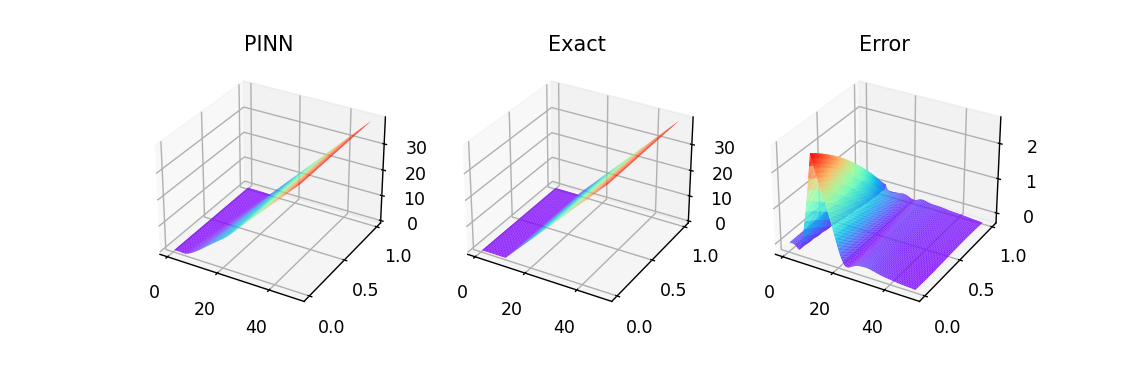

Max abs error is:  2.673039436340332


In [17]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

X = xx.data.numpy().copy().reshape(sample_number - 1,sample_number)
Y = yy.data.numpy().copy().reshape(sample_number - 1,sample_number)
Z = u_pred.data.numpy().copy().reshape(sample_number - 1,sample_number)

filename = "bs_ame_call_implict.csv"
Z_true = numpy.loadtxt(open(filename, "rb"),delimiter=",",skiprows=0)  

fig = plt.figure(figsize=[9,3])
# ax = plt.subplot(3,1,1)
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
#ax.contourf(X, Y, Z, zdir='Z', offset=-2, cmap='rainbow')
#ax.set_zlim(-2,2)
plt.title('PINN') 

ax_true = fig.add_subplot(132, projection='3d')
ax_true.plot_surface(X, Y, Z_true, rstride=1, cstride=1, cmap='rainbow')
#ax.contourf(X, Y, Z, zdir='Z', offset=-2, cmap='rainbow')
#ax.set_zlim(-2,2)
plt.title('Exact') 

ax_error = fig.add_subplot(133, projection='3d')
ax_error.plot_surface(X, Y, Z - Z_true, rstride=1, cstride=1, cmap='rainbow')
#ax.contourf(X, Y, Z, zdir='Z', offset=-2, cmap='rainbow')
#ax.set_zlim(-2,2)
plt.title('Error') 

plt.show()

print("Max abs error is: ", float(np.max(np.abs(Z - Z_true))))